In [1]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


C:\Users\theod\AppData\Roaming\Python\Python39\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def load_data(annotation_file, image_dir, target_size=(224, 224)):
    annotations = pd.read_csv(annotation_file)

    images = []
    bboxes = []

    for _, row in annotations.iterrows():
        x_min = row['xmin']
        y_min = row['ymin']
        x_max = row['xmax']
        y_max = row['ymax']
        width = row['width']
        height = row['height']
        
        bbox = [x_min / width, y_min / height, x_max / width, y_max / height]
        
        img_path = os.path.join(image_dir, row['filename'])
        
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, target_size)
        
        images.append(img)
        bboxes.append(bbox)

    images = np.array(images) / 255.0
    bboxes = np.array(bboxes)
    
    return images, bboxes


In [4]:
annotation_file = r'D:\table_detection\nutrition table.v2i.tensorflow\train\_annotations.csv'
image_dir = r'D:\table_detection\nutrition table.v2i.tensorflow\train'

# Load data
images, bboxes = load_data(annotation_file, image_dir)

In [5]:
def normalize_bbox(bbox, image_width, image_height):
    return [bbox[0] / image_width, bbox[1] / image_height, bbox[2] / image_width, bbox[3] / image_height]

def denormalize_bbox(bbox, image_width, image_height):
    return [int(bbox[0] * image_width), int(bbox[1] * image_height), int(bbox[2] * image_width), int(bbox[3] * image_height)]

def augment_data(image, bboxes, class_labels):
    image_height, image_width = image.shape[:2]

    normalized_bboxes = [normalize_bbox(bbox, image_width, image_height) for bbox in bboxes]

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=15, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.4),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    augmented = transform(image=image, bboxes=normalized_bboxes, class_labels=class_labels)

    augmented_bboxes = [denormalize_bbox(bbox, image_width, image_height) for bbox in augmented['bboxes']]
    return augmented['image'], augmented_bboxes


In [6]:
def create_table_detection_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='sigmoid')  # Output bounding box coordinates (normalized)
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    # model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [13]:
optimizer = Adam(learning_rate=0.0001)

In [14]:
model = create_table_detection_model(input_shape=(224, 224, 3))
checkpoint = ModelCheckpoint('table_detection.h5', monitor='val_loss', save_best_only=True)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 64)       

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=8, callbacks=[early_stopping, checkpoint])

Epoch 1/50
67/67 [==============================] - 4s 48ms/step - loss: 0.0738 - accuracy: 0.4075 - val_loss: 0.0463 - val_accuracy: 0.3881
Epoch 2/50
67/67 [==============================] - 2s 28ms/step - loss: 0.0341 - accuracy: 0.5514 - val_loss: 0.0864 - val_accuracy: 0.6119
Epoch 3/50
67/67 [==============================] - 2s 28ms/step - loss: 0.0295 - accuracy: 0.6112 - val_loss: 0.0887 - val_accuracy: 0.6119
Epoch 4/50
67/67 [==============================] - 2s 26ms/step - loss: 0.0272 - accuracy: 0.6374 - val_loss: 0.0694 - val_accuracy: 0.5522
Epoch 5/50
67/67 [==============================] - 2s 26ms/step - loss: 0.0247 - accuracy: 0.6766 - val_loss: 0.0682 - val_accuracy: 0.5896
Epoch 6/50
67/67 [==============================] - 2s 31ms/step - loss: 0.0218 - accuracy: 0.6841 - val_loss: 0.0550 - val_accuracy: 0.6493
Epoch 7/50
67/67 [==============================] - 2s 26ms/step - loss: 0.0189 - accuracy: 0.6804 - val_loss: 0.0506 - val_accuracy: 0.6269
Epoch 8/50
67

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

5/5 [==============================] - 0s 14ms/step - loss: 0.0353 - accuracy: 0.7388
Test Accuracy: 73.88%


In [18]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [19]:
print("Model's Input Layer:", model.layers[0].input_shape)

Model's Input Layer: (None, 224, 224, 3)


In [20]:
print("Model's ouput Layer:", model.output_shape)

Model's ouput Layer: (None, 4)


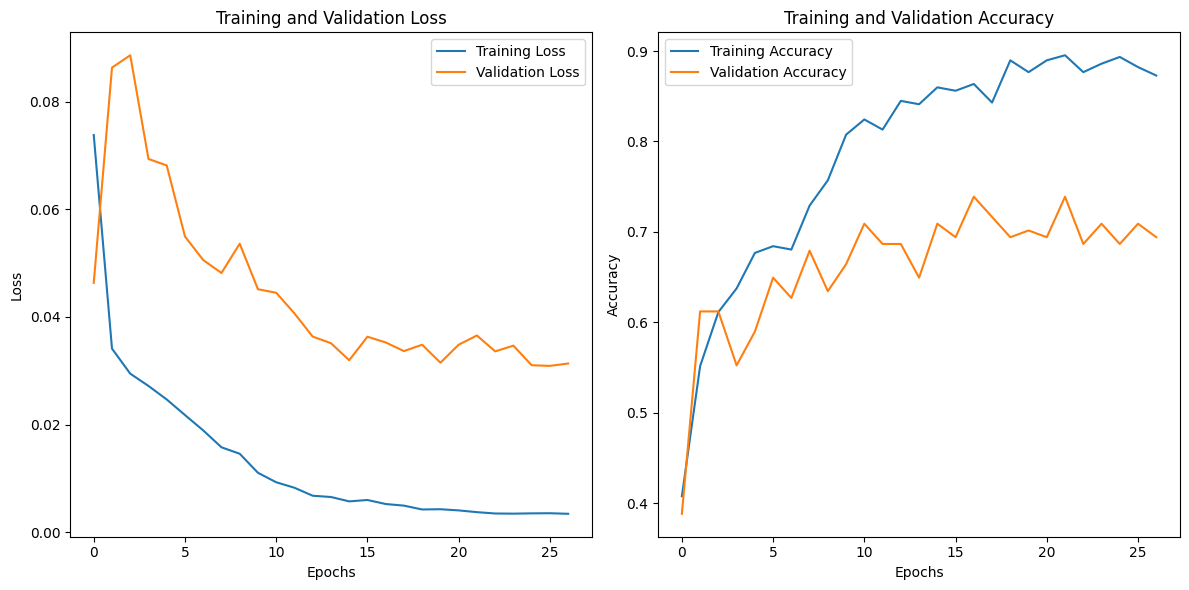

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
tflite_model_path = "bounding_box.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved as TFLite: {tflite_model_path}")


INFO:tensorflow:Assets written to: C:\Users\theod\AppData\Local\Temp\tmpdz5m4lmg\assets


INFO:tensorflow:Assets written to: C:\Users\theod\AppData\Local\Temp\tmpdz5m4lmg\assets


Model saved as TFLite: bounding_box.tflite
